In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
# hyperparameters
image_size = 28
patch_size = 7
num_channels = 1
num_classes = 10
d_model = 8
num_heads = 2
num_layers = 2
learning_rate = 1e-3
batch_size = 64
num_epochs = 20
dropout = 0

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seed
torch.manual_seed(42)

In [3]:
no_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [4]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=no_transform, download=True)
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=no_transform, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)

tensor(7)


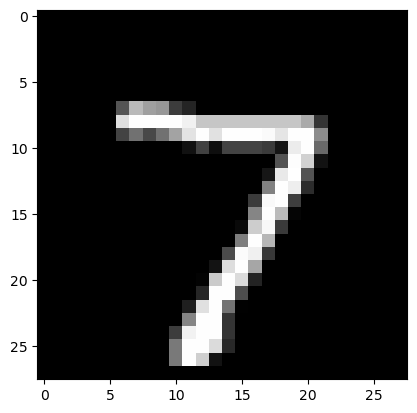

In [5]:
import matplotlib.pyplot as plt

image, label = next(iter(valid_dataloader))

assert image_size == image.shape[-1]
assert num_channels == image.shape[-3]

plt.imshow(image[0].permute(1,2,0), cmap='gray')
print(label[0])

In [6]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, num_classes, embed_dim, num_heads, num_layers, is_cls_tok=False, dropout=0.5):
        super().__init__()
        self.is_cls_tok = is_cls_tok

        # Compute the number of patches
        self.num_patches = (image_size // patch_size) ** 2

        # Patch Embedding
        self.patch_embed = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size) # bias=False

        # Positional encoding
        if is_cls_tok:
            self.cls_tok = nn.Parameter(torch.randn(1, 1, embed_dim))
            self.pos_emb = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))
        else:
            self.cls_tok = None
            self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4, dropout=0.1)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Layer Norm
        self.ln = nn.LayerNorm(embed_dim)

        # Classification Head
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        # Patch Embedding
        x = self.patch_embed(x) # (B, C, H, W)

        # reshape Patches into sequence
        x = x.flatten(2).transpose(1, 2) # (B, T, C), T=H*W
        B, T, C = x.shape

        # add Class Token
        if self.is_cls_tok:
            cls_tokens = self.cls_tok.repeat(B, 1, 1) # (1, 1, C) -> (B, 1, C)
            x = torch.cat([cls_tokens, x], dim=1)

        # add Positional Embedding
        x = x + self.pos_emb # [:, : T + 1, :]

        # Dropout
        x = self.dropout(x)

        # Transformer Encoder
        x = self.encoder(x)

        # Classification Head
        if self.is_cls_tok:
            x = x[:,0]
        else:
            x = x.mean(dim=1)  # global average pooling
        x = self.ln(x)
        x = self.classification_head(x)

        return x

In [7]:
# define model
model = ViT(image_size, patch_size, num_channels, num_classes, d_model, num_heads, num_layers, is_cls_tok=False, dropout=dropout).to(device)
print('# of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
# model = torch.compile(model) # requires pytorch >= 2.0

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# loss function
criterion = nn.CrossEntropyLoss()

# of parameters: 2378


In [8]:
model(torch.randn(1,1,28,28))

tensor([[-0.0690, -0.1162, -0.0692,  0.7432,  1.4880,  0.2868,  0.2489,  0.6058,
          0.2520, -0.4912]], grad_fn=<AddmmBackward0>)

In [9]:
def train(model, dataloader):

    model.train()

    # accumulate loss across batches
    running_loss = 0.0
    running_accuracy = 0.0

    for x, y in dataloader:
        #x, y = batch[0].to(device), batch[1].to(device) # move to device

        optimizer.zero_grad() # reset gradients
        y_pred = model(x) # forward pass
        loss = criterion(y_pred, y) # calculate loss
        loss.backward() # compute gradients
        optimizer.step() # optimization step

        running_loss += loss
        running_accuracy += (y_pred.argmax(dim=1) == y).float().mean()

    # average loss across batches
    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)

    return loss, accuracy

In [10]:
@torch.no_grad()
def valid(model, dataloader):

    model.eval()

    # accumulate loss across batches
    running_loss = 0.0
    running_accuracy = 0.0

    for x, y in dataloader:
        #x, y = x.to(device), y.to(device) # move to device

        y_pred = model(x) # forward pass
        loss = criterion(y_pred, y) # calculate loss

        running_loss += loss
        running_accuracy += (y_pred.argmax(dim=1) == y).float().mean()
    
    # average loss across batches
    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)

    return loss, accuracy

In [11]:
# keep track of losses
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    print(f'epoch {epoch}')
    print('training')
    loss, accuracy = train(model, train_dataloader)
    train_losses.append(loss)
    train_accs.append(accuracy)
    print(f'loss: {loss}, accuracy: {accuracy}')
    
    print('validating')
    loss, accuracy = valid(model, train_dataloader)
    valid_losses.append(loss)
    valid_accs.append(accuracy)
    print(f'val_loss: {loss}, val_accuracy: {accuracy}')

epoch 0
training
loss: 1.485443353652954, accuracy: 0.49623534083366394
validating
val_loss: 0.8647183775901794, val_accuracy: 0.7336587309837341
epoch 1
training
loss: 0.8330589532852173, accuracy: 0.7375233173370361
validating
val_loss: 0.5992007255554199, val_accuracy: 0.8182802796363831
epoch 2
training
loss: 0.677836000919342, accuracy: 0.7886627316474915
validating
val_loss: 0.5205157399177551, val_accuracy: 0.8437999486923218
epoch 3
training
loss: 0.6038737297058105, accuracy: 0.813449501991272
validating
val_loss: 0.4616297781467438, val_accuracy: 0.8656716346740723
epoch 4
training
loss: 0.5553653836250305, accuracy: 0.8284748196601868
validating
val_loss: 0.43336594104766846, val_accuracy: 0.8681703209877014
epoch 5
training
loss: 0.5251518487930298, accuracy: 0.8390524983406067
validating
val_loss: 0.40662652254104614, val_accuracy: 0.8812466859817505
epoch 6
training
loss: 0.4988752603530884, accuracy: 0.8482975959777832
validating
val_loss: 0.40625128149986267, val_accura